In [85]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests


In [86]:
#Загружаем данные

installs = pd.read_csv('data/installs.csv')
logins = pd.read_csv('data/logins.csv')
payments = pd.read_csv('data/payments.csv')


# Описание данных

In [87]:
#Проверяем на пропуски
installs.info()
logins.info()
payments.info()

#Пропусков в данных нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109046 entries, 0 to 109045
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   timestamp  109046 non-null  int64
 1   user_id    109046 non-null  int64
 2   group      109046 non-null  int64
dtypes: int64(3)
memory usage: 2.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677798 entries, 0 to 677797
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   timestamp  677798 non-null  int64
 1   user_id    677798 non-null  int64
 2   group      677798 non-null  int64
dtypes: int64(3)
memory usage: 15.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18943 entries, 0 to 18942
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    18943 non-null  int64  
 1   user_id      18943 non-null  int64  
 2   group        18943 non-null  int

In [88]:
# Посмотрим на доступные к покупке опции для каждой группы
# Покупки контрольной группы
payments[ payments.group == 1 ].groupby('payment_tag')['price'].agg('unique')

payment_tag
Common          [4.99, 9.99, 19.99, 49.99, 99.99, 249.99]
Starter_pack                                       [4.99]
Name: price, dtype: object

In [89]:
# Покупки группы 2
payments[ payments.group == 2 ].groupby('payment_tag')['price'].agg('unique')

payment_tag
Common          [4.99, 9.99, 19.99, 49.99, 99.99, 249.99]
Starter_pack                                       [0.99]
Name: price, dtype: object

In [90]:
# Покупки группы 2
payments[ payments.group == 3 ].groupby('payment_tag')['price'].agg('unique')

payment_tag
Common            [4.99, 9.99, 19.99, 49.99, 99.99, 249.99]
Daily_supplies                                [9.99, 19.99]
Starter_pack                                         [4.99]
Name: price, dtype: object

In [91]:
# Установки, логины, покупки

print(
    f'Количество уникальных установок:{installs.user_id.nunique()}, \n'
    f'Количество уникальных логинов: {logins.user_id.nunique()}, \n'
    f'Количество уникальных покупателей: {payments.user_id.nunique()}'

)

Количество уникальных установок:109046, 
Количество уникальных логинов: 108651, 
Количество уникальных покупателей: 2698


In [92]:
# Доход всего

print(
    f'Доход всего: ${payments.price.sum()}\n'
)

Доход всего: $310620.57



In [93]:
# Доход по группам
pd.DataFrame(payments.groupby('group')['price'].sum())

,price
group,
1,111063.43
2,84773.95
3,114783.19


In [94]:
# Перед объединением данных и проведением тестов проверим корректность данных
# - каждый пользователь должен находиться только в одной группе

installs[ installs.user_id.duplicated(keep=False) ==True ]
# У каждого пользователя только одна установка

,timestamp,user_id,group


In [95]:
# Пользователи в датасете logins, записанные несколько раз, должны относяться только к одной группе.
# Появление нескольких записей нормально - пользователи логинятся несколько раз, но нужно проверить нет ли ошибки
# - не отнесены ли пользователи к разным группам.
logins[ logins.user_id.duplicated(keep=False) ==True ].\
    groupby('user_id').\
    agg({'group':'unique'}).\
    sort_values(ascending=False, by='group')

# Каждый пользователь относится только к одной группе

,group
user_id,
304942768015,[3]
300648256951,[3]
300648257198,[3]
300648257179,[3]
300648030553,[3]
...,...
300648261532,[1]
300648027453,[1]
300648027376,[1]


In [96]:
# Пользователи в датасете payments, записанные несколько раз, должны относяться только к одной группе
# С данными о покупке тоже самое - пользователи могут покупать несколько раз, но нужно проверить нет ли ошибки
# - не отнесены ли пользователи к разным группам
payments[ payments.user_id.duplicated(keep=False) ==True ].\
    groupby('user_id').\
    agg({'group':'unique'}).\
    sort_values(ascending=False, by='group')

# Каждый пользователь относится только к одной группе

,group
user_id,
266287989980,[3]
300648141259,[3]
300648125576,[3]
300648125743,[3]
300648126866,[3]
...,...
300648219058,[1]
300648220143,[1]
300648220449,[1]


Все пользователи относятся только к одной группе, в данных нет ошибок

In [97]:
# Длительность теста
# Привести все таймстампы к дейт тайму
installs['datetime'] = pd.to_datetime(installs['timestamp'], unit='s')
logins['datetime'] = pd.to_datetime(logins['timestamp'], unit='s')
payments['datetime'] = pd.to_datetime(payments['timestamp'], unit='s')

print(
    f'Длительность A/B/C-теста: {logins.datetime.max()-logins.datetime.min()}'
)



Длительность A/B/C-теста: 90 days 21:02:44


# Описание данных:
Есть 3 тестовые группы:
- контрольная,
- облегченный стартовый набор, стоимость ниже обычной в 5 раз, наполнение в 2 раза
- более выгодные daily supplies - отдельные наборы ресурсов (3 вида), получение части покупки происходит в течение 30 дней
___________________
**Контрольная группа**

Стартер пак, $4.99

Обычные наборы, $4.99, $9.99, $19.99, $49.99, $99.99, $249.99

___________________
**Группа 2**
Облегченный стартер пак, $0.99

Обычные наборы, $4.99, $9.99, $19.99, $49.99, $99.99, $249.99

___________________
**Группа 3**
Стартер пак, $4.99

Daily supplies, $9.99, $19.99

Обычные наборы, $4.99, $9.99, $19.99, $49.99, $99.99, $249.99

___________________

Скорее всего тестируется несколько гипотез:
- Чем руководствуются пользователи: дешевизна или выгода?
- Станут ли пользователи чаще конвертироваться в покупку, если снизить порог входа? (группа 2)
- Будут ли пользователи, которые совершили небольшую первую покупку затем играть и тратить столько же, сколько и другие? (группа 2)
- Как на пользователей влияет фактор длительности получения покупки? (группа 3)
- Нужны ли пользователям отдельные наборы ресурсов? (группа 3)


# Расчет метрик


In [98]:
# Оставляем только записи с первыми логинами

# Группируем датасет logins по user_id и group, выбираем минимальную и максимальную дату для каждого юзера
first_logins = logins.groupby(['user_id', 'group'])\
     .agg({'datetime':['min', 'max']}).reset_index(col_level=1)

# Убираем многоуровневость из названий колонок
first_logins.columns = first_logins.columns.droplevel(level=0)

# Переименовываем
first_logins.rename(columns={'min': 'datetime_first_login', 'max':'datetime_last_login'}, inplace=True)
first_logins.head()



,user_id,group,datetime_first_login,datetime_last_login
0,266287989849,1,2005-05-20 00:44:40,2005-05-28 08:28:30
1,266287989850,1,2005-05-20 00:50:18,2005-05-21 00:33:44
2,266287989854,3,2005-05-20 01:50:44,2005-05-20 04:34:59
3,266287989859,3,2005-05-20 02:11:27,2005-05-20 06:32:46
4,266287989862,1,2005-05-20 02:29:02,2005-05-20 02:32:30


In [99]:
# Добавляем к логинам все платежи

# Объединяем датасет logins с payments
first_logins_payments = first_logins.merge(
    payments[['user_id', 'datetime', 'payment_tag', 'price']],
    how='left',
    on='user_id',
)

# Переименовываем
first_logins_payments.rename(columns={'datetime': 'datetime_payment'}, inplace=True)
first_logins_payments

#Каждый пользователь продублирован по количеству платежей

,user_id,group,datetime_first_login,datetime_last_login,datetime_payment,payment_tag,price
0,266287989849,1,2005-05-20 00:44:40,2005-05-28 08:28:30,NaT,NaN,NaN
1,266287989850,1,2005-05-20 00:50:18,2005-05-21 00:33:44,NaT,NaN,NaN
2,266287989854,3,2005-05-20 01:50:44,2005-05-20 04:34:59,NaT,NaN,NaN
3,266287989859,3,2005-05-20 02:11:27,2005-05-20 06:32:46,NaT,NaN,NaN
4,266287989862,1,2005-05-20 02:29:02,2005-05-20 02:32:30,NaT,NaN,NaN
...,...,...,...,...,...,...,...
124891,304942768015,3,2005-07-19 23:55:01,2005-08-15 23:13:09,NaT,NaN,NaN
124892,304942768019,2,2005-07-19 23:56:43,2005-07-19 23:56:43,NaT,NaN,NaN
124893,304942768024,1,2005-07-19 23:59:14,2005-07-19 23:59:14,NaT,NaN,NaN
124894,304942768030,1,2005-07-19 23:59:35,2005-07-19 23:59:35,NaT,NaN,NaN


# ARPU

In [100]:
# Считаем ARPU по тестовым группам
#Заполняем null на 0
first_logins_payments.fillna(value={'price':0}, inplace=True)

# Группируем по тестовым группым и считаем метрики
arpu_per_group = first_logins_payments.groupby('group')\
    .agg(
    {
        'price': [sum],
        'user_id': ['nunique']
    }
)

# Убираем многоуровневость из колонок, переименовываем колонки
arpu_per_group.columns = arpu_per_group.columns.droplevel(level=0)
arpu_per_group.rename(columns={'nunique': 'unique_users', 'sum':'revenue'}, inplace=True)
arpu_per_group['arpu'] = arpu_per_group.revenue/arpu_per_group.unique_users

arpu_per_group

,revenue,unique_users,arpu
group,,,
1,111063.43,36059,3.080047
2,84773.95,36578,2.317621
3,114783.19,36014,3.187182


### Способ расчета:
- Используя bootstrap считаем ARPU на подвыборках по группам
- Находим попарно разницы ARPU для каждой пары
- Проверяем входит ли 0 в доверительный интервал

In [101]:
# Разделим данные на группы
control = first_logins_payments[first_logins_payments['group'] == 1]
group2 = first_logins_payments[first_logins_payments['group'] == 2]
group3 = first_logins_payments[first_logins_payments['group'] == 3]

In [102]:
# Используем bootstrap для создания распределений ARPU

boot_1= []
for i in range(10000):
    boot_sample = control.sample(frac = 1.0, replace = True)
    boot_arpu = sum(boot_sample.price)/boot_sample.user_id.nunique()
    boot_1.append(boot_arpu)
boot_1 = pd.DataFrame(boot_1)

boot_2= []
for i in range(10000):
    boot_sample = group2.sample(frac = 1.0, replace = True)
    boot_arpu = sum(boot_sample.price)/boot_sample.user_id.nunique()
    boot_2.append(boot_arpu)
boot_2 = pd.DataFrame(boot_2)

boot_3= []
for i in range(10000):
    boot_sample = group3.sample(frac = 1.0, replace = True)
    boot_arpu = sum(boot_sample.price)/boot_sample.user_id.nunique()
    boot_3.append(boot_arpu)
boot_3 = pd.DataFrame(boot_3)

In [103]:
# Рассчитаем разницу

boot1_2 = boot_1-boot_2
boot1_3 = boot_1-boot_3
boot2_3 = boot_2-boot_3

c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

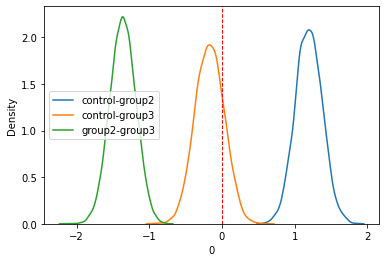

In [104]:
# Визуализируем распределения

fig, ax = plt.subplots()
sns.distplot(boot1_2[0], hist=False)
sns.distplot(boot1_3[0], hist=False)
sns.distplot(boot2_3[0], hist=False)
plt.axvline( x=0.0, color='r', linestyle='dashed', linewidth=1, label=f'mean')
ax.legend(['control-group2', 'control-group3', 'group2-group3'])
plt.show()

#Для контрольной и группы 3 скорее всего статистически значимой разницы нет

Комментарий:

При проведении t-теста и z-теста, а так же расчете доверительного интервала с помощью st.t.interval возникает проблема:
доверительный интервал получается слишком узким, ноль в него не входит.
Но визуально и при расчете доверительно интервала с помощью np.percentile результаты получаются корректными.
Установить причину проблемы не удалось, подробнее: [ссылка на ноутбук]()

Для оценки ARPU будет использоваться только доверительный интервал, без расчета p-value.

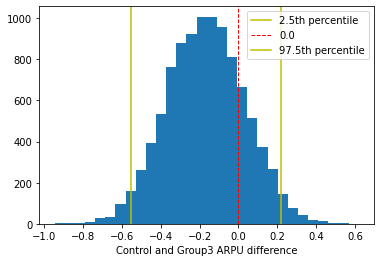

In [105]:
# Строим гистограмму распределения разниц ARPU контрольной и группы 3
plt.hist(boot1_3,bins=30)

# Визуализируем 95% доверительный интервал
plt.axvline(x=np.percentile(boot1_3,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline( x=0.0, color='r', linestyle='dashed', linewidth=1, label=f'0.0')
plt.axvline(x=np.percentile(boot1_3,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='y')

plt.xlabel("Control and Group3 ARPU difference")
plt.legend()
plt.show()

# Ноль входит в доверительный интервал разницы распределений ARPU контрольной и группы 3

In [106]:
# Получаем значения 2.5 и 97.5 перцентилей
conf_interval = np.percentile(boot1_3,[2.5,97.5])

# Проверим входит ли ноль в доверительный интервал
if np.percentile(boot1_3,[2.5]) <0< np.percentile(boot1_3,[97.5]):
    print(
        "Ноль входит в доверительный интервал разницы распределений \n"
        "Статитически значимой разницы нет (Не достаточно оснований отклонить гипотезу H0)"
    )
else:
    print(
        "Ноль не входит в доверительный интервал разницы распределений \n"
        "Статитически значимая разница есть (Есть основания отклонить гипотезу H0)"
    )

Ноль входит в доверительный интервал разницы распределений 
Статитически значимой разницы нет (Не достаточно оснований отклонить гипотезу H0)


In [107]:
# Сохраним результаты в переменную
arpu_1_3_reject = not (np.percentile(boot1_3,[2.5]) <0< np.percentile(boot1_3,[97.5]))[0]
arpu_1_3_reject

False

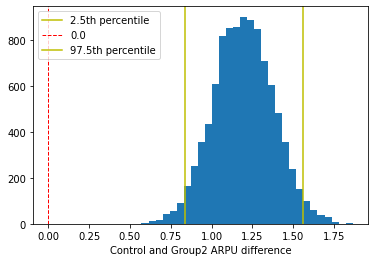

In [108]:
# Строим гистограмму распределения разниц ARPU контрольной и группы 2
plt.hist(boot1_2,bins=30)

# Визуализируем 95% доверительный интервал
plt.axvline(x=np.percentile(boot1_2,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline( x=0.0, color='r', linestyle='dashed', linewidth=1, label=f'0.0')
plt.axvline(x=np.percentile(boot1_2,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='y')

plt.xlabel("Control and Group2 ARPU difference")
plt.legend()
plt.show()

# Ноль не входит в доверительный интервал разницы распределений ARPU контрольной и группы 2

In [109]:
# Получаем значения 2.5 и 97.5 перцентилей
conf_interval = np.percentile(boot1_2,[2.5,97.5])

# Проверим входит ли ноль в доверительный интервал
if np.percentile(boot1_2,[2.5]) <0< np.percentile(boot1_2,[97.5]):
    print(
        "Ноль входит в доверительный интервал разницы распределений \n"
        "Статитически значимой разницы нет (Не достаточно оснований отклонить гипотезу H0)"
    )
else:
    print(
        "Ноль не входит в доверительный интервал разницы распределений \n"
        "Статитически значимая разница есть (Есть основания отклонить гипотезу H0)"
    )

Ноль не входит в доверительный интервал разницы распределений 
Статитически значимая разница есть (Есть основания отклонить гипотезу H0)


In [110]:
# Сохраним результаты в переменную
arpu_1_2_reject = not (np.percentile(boot1_2,[2.5]) <0< np.percentile(boot1_2,[97.5]))[0]
arpu_1_2_reject

True

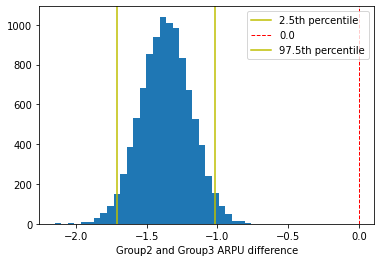

In [111]:
# Строим гистограмму распределения разниц группы 2 и группы 3
plt.hist(boot2_3,bins=30)

# Визуализируем 95% доверительный интервал
plt.axvline(x=np.percentile(boot2_3,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline( x=0.0, color='r', linestyle='dashed', linewidth=1, label=f'0.0')
plt.axvline(x=np.percentile(boot2_3,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='y')

plt.xlabel("Group2 and Group3 ARPU difference")
plt.legend()
plt.show()

# Ноль не входит в доверительный интервал разницы распределений группы 2 и группы 3

In [112]:
# Получаем значения 2.5 и 97.5 перцентилей
conf_interval = np.percentile(boot2_3,[2.5,97.5])

# Проверим входит ли ноль в доверительный интервал
if np.percentile(boot2_3,[2.5]) <0< np.percentile(boot2_3,[97.5]):
    print(
        "Ноль входит в доверительный интервал разницы распределений \n"
        "Статитически значимой разницы нет (Не достаточно оснований отклонить гипотезу H0)"
    )
else:
    print(
        "Ноль не входит в доверительный интервал разницы распределений \n"
        "Статитически значимая разница есть (Есть основания отклонить гипотезу H0)"
    )

Ноль не входит в доверительный интервал разницы распределений 
Статитически значимая разница есть (Есть основания отклонить гипотезу H0)


In [113]:
# Сохраним результаты в переменную
arpu_2_3_reject = not (np.percentile(boot2_3,[2.5]) <0< np.percentile(boot2_3,[97.5]))[0]
arpu_2_3_reject

True

In [114]:
#Создадим датасет с разницей в ARPU между группами
arpu_diff = pd.DataFrame(
    [arpu_per_group.arpu[1] - arpu_per_group.arpu[2],
    arpu_per_group.arpu[1] - arpu_per_group.arpu[3],
    arpu_per_group.arpu[2] - arpu_per_group.arpu[3]],
    columns=['arpu_difference'],
    index=['1-2', '1-3',  '2-3']
)
arpu_diff['reject'] = [arpu_1_2_reject, arpu_1_3_reject, arpu_2_3_reject]
arpu_diff

,arpu_difference,reject
1-2,0.762426,True
1-3,-0.107135,False
2-3,-0.869561,True


Вывод: статистически значимая разница есть только между второй и другими группами.
Между контрольной и группой 3 статистически значимой разницы нет.
ARPU группы 2 ниже остальных

# Conversion rate to payment

In [115]:
# Рассчитаем значение CR

payments_per_user = first_logins_payments.\
    groupby(['user_id', 'group', 'datetime_first_login', 'datetime_last_login']).\
    agg({'price': 'sum'}).reset_index()

CR_per_group = payments_per_user.groupby('group')\
    .agg(
    {
        'user_id': 'nunique',
        'price': lambda x: (x>0).sum(),
    }
)

CR_per_group['conv_rate'] = 100*(CR_per_group['price']/CR_per_group['user_id'])
CR_per_group.rename(columns={'user_id':'all_users', 'price':'converted_users'}, inplace=True)
CR_per_group

,all_users,converted_users,conv_rate
group,,,
1,36059,853,2.365568
2,36578,1014,2.772158
3,36014,831,2.307436


Для расчета статистической значимости конверсий можно использовать:
- нормализацию и z-test, метод Бонферрони-Холма для правки уровня значимости при множественных сравнениях

## Z-test for CR

Z-test условия:
- Данные в генеральной совокупности распределены нормально
- Размер выборки n>30

In [116]:
# Добавим колонку сконвертировался ли юзер в оплату, для дальнейших расчетов
payments_per_user['is_converted'] = payments_per_user.price>0.0
payments_per_user

,user_id,group,datetime_first_login,datetime_last_login,price,is_converted
0,266287989849,1,2005-05-20 00:44:40,2005-05-28 08:28:30,0.0,False
1,266287989850,1,2005-05-20 00:50:18,2005-05-21 00:33:44,0.0,False
2,266287989854,3,2005-05-20 01:50:44,2005-05-20 04:34:59,0.0,False
3,266287989859,3,2005-05-20 02:11:27,2005-05-20 06:32:46,0.0,False
4,266287989862,1,2005-05-20 02:29:02,2005-05-20 02:32:30,0.0,False
...,...,...,...,...,...,...
108646,304942768015,3,2005-07-19 23:55:01,2005-08-15 23:13:09,0.0,False
108647,304942768019,2,2005-07-19 23:56:43,2005-07-19 23:56:43,0.0,False
108648,304942768024,1,2005-07-19 23:59:14,2005-07-19 23:59:14,0.0,False
108649,304942768030,1,2005-07-19 23:59:35,2005-07-19 23:59:35,0.0,False


In [117]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Оставляем только колонку - сконвертировался ли пользователь
control_results = payments_per_user[payments_per_user['group'] == 1]['is_converted']
group2_results = payments_per_user[payments_per_user['group'] == 2]['is_converted']
group3_results = payments_per_user[payments_per_user['group'] == 3]['is_converted']

# Считаем количество всех пользователей
n_con = control_results.count()
n_group2 = group2_results.count()
n_group3 = group3_results.count()

# Количество сконвертировавшихся пользователей
successes = [control_results.sum(), group2_results.sum(), group3_results.sum()]
nobs = [n_con, n_group2, n_group3]

In [118]:
# Посчитаем доверительные интервалы
(lower_con, lower_group2, lower_group3), (upper_con, upper_group2, upper_group3) = \
    proportion_confint(successes, nobs=nobs, alpha=0.05)

# Доверительные интервалы
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment 2nd group: [{lower_group2:.3f}, {upper_group2:.3f}]')
print(f'ci 95% for treatment 3rd group: [{lower_group3:.3f}, {upper_group3:.3f}]')

# Скорее всего, значимые отличия есть только для второй группы - ее доверительный интервал не пересекается с другими

ci 95% for control group: [0.022, 0.025]
ci 95% for treatment 2nd group: [0.026, 0.029]
ci 95% for treatment 3rd group: [0.022, 0.025]


In [119]:
# Proportion z-test для control и group 2

z_stat1, p_val1 = proportions_ztest(
    [control_results.sum(), group2_results.sum()],
    nobs=[n_con, n_group2]
)
print(f'z statistic: {z_stat1:.2f}')
print(f'p-value: {p_val1:.3f}')

alpha = 0.05
if p_val1 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: -3.46
p-value: 0.001
Z-test: Samples means are not equal (can reject H0) 



In [120]:
# Proportion z-test для control и group 3

z_stat2, p_val2 = proportions_ztest(
    [control_results.sum(), group3_results.sum()],
    nobs=[n_con, n_group3]
)
print(f'z statistic: {z_stat2:.2f}')
print(f'p-value: {p_val2:.3f}')

alpha = 0.05
if p_val2 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: 0.52
p-value: 0.605
Z-test: Samples have equal means (fail to reject H0) 



In [121]:
# test group2, group3
z_stat3, p_val3 = proportions_ztest(
    [group2_results.sum(), group3_results.sum()],
    nobs=[n_group2, n_group3]
)
print(f'z statistic: {z_stat3:.2f}')
print(f'p-value: {p_val3:.5f}')

alpha = 0.05
if p_val3 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: 3.98
p-value: 0.00007
Z-test: Samples means are not equal (can reject H0) 



In [122]:
# Добавим результаты в один датасет
CR_z_tets = pd.DataFrame(np.array([
    ['1-2', z_stat1, p_val1],
    ['1-3', z_stat2, p_val2],
    ['2-3', z_stat3, p_val3]
]),
    columns=['pairs', 'z_stat', 'p_value'])
CR_z_tets[['z_stat', 'p_value']] = CR_z_tets[['z_stat', 'p_value']].apply(pd.to_numeric)
CR_z_tets

,pairs,z_stat,p_value
0,1-2,-3.462233,0.000536
1,1-3,0.516556,0.605466
2,2-3,3.977692,0.000070


In [123]:
# Делаем поправку на множественное сравнение
res = multipletests(pvals=CR_z_tets.p_value, alpha=0.05, method='h')
print(res[0], res[1])
CR_z_tets['adjusted_p'] = res[1]
CR_z_tets['reject'] = res[0]
CR_z_tets

[ True False  True] [1.07142514e-03 6.05466276e-01 2.08761945e-04]


,pairs,z_stat,p_value,adjusted_p,reject
0,1-2,-3.462233,0.000536,0.001071,True
1,1-3,0.516556,0.605466,0.605466,False
2,2-3,3.977692,0.000070,0.000209,True


Вторая группа значимо лучше конвертирует в оплату, размер эффекта ~ 0,4%.
Т.е. разница в 4 человека с 1000 по сравнению с другими группами.
Между контрольной и третьей группой статистически значимых различий нет.

# Retention 30

In [124]:
# Рассчитать метрики

# Добавим к логинам информацию сконвертировался ли пользователь в покупки или нет
logins_conv = logins.merge(
    payments_per_user[['user_id', 'is_converted', 'datetime_first_login', 'datetime_last_login']],
    how='left',
    on='user_id'
)
# Меняем тип данных - убираем время и оставляем только дату (для расчета retention)
logins_conv['datetime_first_login'] = logins_conv['datetime_first_login'].dt.date
logins_conv['datetime_last_login'] = logins_conv['datetime_last_login'].dt.date
logins_conv['datetime'] = logins_conv['datetime'].dt.date
logins_conv

# Добавляем колонку seniority с "возрастом" пользователя в днях
logins_conv['seniority']= (logins_conv['datetime'] - logins_conv['datetime_first_login']).dt.days
logins_conv

,timestamp,user_id,group,datetime,is_converted,datetime_first_login,datetime_last_login,seniority
0,1116547257,300647965937,2,2005-05-20,False,2005-05-20,2005-05-20,0
1,1116547342,300647965938,2,2005-05-20,False,2005-05-20,2005-06-03,0
2,1116547342,300647965942,1,2005-05-20,False,2005-05-20,2005-05-20,0
3,1116547567,300647965950,2,2005-05-20,False,2005-05-20,2005-05-20,0
4,1116547730,300647965957,3,2005-05-20,False,2005-05-20,2005-06-18,0
...,...,...,...,...,...,...,...,...
677793,1124396026,304942767229,3,2005-08-18,False,2005-07-19,2005-08-18,30
677794,1124396556,279172901200,1,2005-08-18,False,2005-07-19,2005-08-18,30
677795,1124397311,304942767681,1,2005-08-18,True,2005-07-19,2005-08-18,30
677796,1124398255,304942767525,1,2005-08-18,False,2005-07-19,2005-08-18,30


In [125]:
#Группируем записи по дате первого логина и "возрасту", считаем количество записей
cohort_data = logins_conv.groupby(['datetime_first_login', 'seniority'])['user_id'].size().reset_index()

# Разворачиваем таблицу, индекс-когорты, колонки-"возраст"
cohorts_size = cohort_data.pivot(index='datetime_first_login', columns='seniority', values='user_id')

# Выделяем 0 день, чтобы с помощью него посчитать конверсии
base = cohorts_size[0]
cohorts_retention = cohorts_size.divide(base, axis=0).round(3)*100
cohorts_retention.style.background_gradient()

seniority,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
datetime_first_login,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-05-20,100.000000,22.700000,18.600000,12.900000,13.400000,15.400000,14.200000,14.900000,13.500000,14.100000,9.900000,9.900000,12.500000,12.300000,12.300000,11.500000,12.200000,8.900000,10.500000,11.300000,10.800000,10.100000,10.400000,8.100000,6.400000,8.300000,9.300000,8.400000,8.900000,8.600000,4.600000
2005-05-21,100.000000,22.500000,18.400000,17.000000,16.100000,14.500000,14.400000,15.500000,13.100000,10.900000,12.300000,12.300000,12.200000,11.900000,9.200000,9.900000,10.000000,8.800000,9.600000,9.100000,8.500000,8.200000,7.300000,7.800000,8.000000,8.900000,9.700000,9.600000,8.000000,8.300000,3.500000
2005-05-22,100.000000,16.900000,12.300000,14.800000,12.100000,12.400000,11.600000,10.200000,9.500000,9.000000,10.000000,9.200000,9.000000,9.700000,8.100000,7.200000,8.900000,10.700000,8.200000,8.500000,10.300000,8.000000,8.000000,10.200000,10.300000,10.100000,9.900000,8.000000,8.900000,7.700000,3.700000
2005-05-23,100.000000,27.400000,19.100000,16.400000,16.200000,14.400000,15.600000,15.700000,15.600000,14.900000,13.200000,12.300000,13.700000,14.400000,11.700000,13.300000,13.400000,12.300000,12.700000,11.400000,12.000000,12.100000,12.300000,10.500000,9.500000,11.100000,10.000000,10.700000,10.200000,11.400000,4.600000
2005-05-24,100.000000,23.600000,19.100000,16.300000,16.600000,13.300000,15.300000,16.000000,13.000000,12.200000,13.000000,12.900000,12.700000,12.600000,15.700000,12.400000,10.700000,11.400000,12.300000,10.600000,11.600000,11.100000,11.700000,10.500000,9.300000,9.600000,9.800000,9.800000,10.600000,9.300000,4.100000
2005-05-25,100.000000,22.200000,17.500000,15.100000,11.700000,10.800000,12.900000,11.600000,9.800000,8.300000,10.100000,9.500000,8.100000,9.100000,11.300000,9.900000,10.100000,8.800000,8.200000,6.700000,6.000000,7.800000,7.200000,6.400000,5.900000,6.300000,6.700000,6.800000,6.500000,7.000000,4.000000
2005-05-26,100.000000,21.500000,14.000000,11.500000,7.400000,9.400000,11.600000,10.000000,9.600000,9.400000,8.400000,5.900000,7.100000,8.300000,8.000000,7.000000,6.800000,5.800000,5.200000,5.600000,6.600000,6.400000,7.000000,6.800000,7.800000,6.200000,6.500000,6.600000,6.600000,6.600000,3.000000
2005-05-27,100.000000,25.600000,19.600000,16.100000,14.000000,15.700000,14.700000,15.000000,12.600000,13.400000,13.800000,12.600000,13.300000,13.600000,12.400000,11.700000,10.700000,10.100000,10.900000,11.800000,12.800000,12.200000,10.900000,12.700000,10.900000,10.200000,11.300000,12.000000,11.700000,10.200000,5.600000
2005-05-28,100.000000,22.600000,13.400000,13.600000,14.600000,13.000000,9.800000,12.700000,11.200000,8.200000,7.900000,10.100000,10.000000,10.100000,10.800000,10.600000,9.100000,7.900000,9.000000,9.300000,7.700000,8.900000,9.200000,7.900000,8.000000,8.300000,9.100000,9.400000,9.200000,7.900000,3.400000


In [126]:
# Посмотрим ретеншен по группам, а не по когортам

# Оставим только нужные колонки и уберем дубликаты
logins_groups =  logins_conv[['group', 'seniority', 'user_id']].drop_duplicates()

# Группируем записи по тестовой группе и "возрасту", считаем количество записей
group_data = logins_groups.groupby(['group', 'seniority'])['user_id'].size().reset_index()

# Разворачиваем таблицу, индекс-группы, колонки-"возраст"
groups_size = group_data.pivot(index='group', columns='seniority', values='user_id')
base = groups_size[0]
groups_retention = groups_size.divide(base, axis=0).round(5)*100

# Выделим ячейки цветом по "возрасту"
groups_retention.style.background_gradient()

seniority,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,100.000000,12.069000,8.217000,6.634000,5.835000,5.541000,5.322000,5.150000,4.739000,4.407000,4.176000,4.041000,4.005000,4.043000,4.021000,3.738000,3.736000,3.638000,3.572000,3.547000,3.544000,3.541000,3.397000,3.314000,3.317000,3.247000,3.159000,3.145000,3.275000,3.173000,2.349000
2,100.000000,12.163000,8.366000,6.646000,5.774000,5.402000,5.189000,5.159000,4.664000,4.369000,4.183000,3.989000,3.994000,3.945000,3.907000,3.808000,3.633000,3.508000,3.431000,3.376000,3.453000,3.409000,3.319000,3.207000,3.158000,3.133000,3.138000,3.095000,3.147000,3.070000,2.313000
3,100.000000,12.195000,8.358000,6.545000,6.000000,5.573000,5.390000,5.240000,4.868000,4.554000,4.387000,4.246000,4.196000,4.060000,4.051000,3.935000,3.765000,3.599000,3.596000,3.554000,3.529000,3.515000,3.540000,3.282000,3.279000,3.249000,3.310000,3.282000,3.318000,3.265000,2.430000


In [127]:
# Сохраняем retention 1, 7, 30 в отдельный датасет
retention_1_7_30 = groups_retention[[1, 7, 30]]
retention_1_7_30.rename(columns={1:'retention_1', 7:'retention_7', 30:'retention_30'}, inplace=True)
retention_1_7_30

c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


seniority,retention_1,retention_7,retention_30
group,,,
1,12.069,5.150,2.349
2,12.163,5.159,2.313
3,12.195,5.240,2.430


In [128]:
# Добавляем поле returned_30 - вернулся ли пользователь на 30 день
logins_conv['returned_30'] = (logins_conv.datetime_last_login - logins_conv.datetime_first_login).\
                                 dt.days.astype('int16') >= 30
# Оставляем только одну запись на пользователя
logins_unique = \
    logins_conv[['user_id', 'group', 'datetime_first_login', 'datetime_last_login', 'is_converted', 'returned_30']].\
    drop_duplicates()
logins_unique

,user_id,group,datetime_first_login,datetime_last_login,is_converted,returned_30
0,300647965937,2,2005-05-20,2005-05-20,False,False
1,300647965938,2,2005-05-20,2005-06-03,False,False
2,300647965942,1,2005-05-20,2005-05-20,False,False
3,300647965950,2,2005-05-20,2005-05-20,False,False
4,300647965957,3,2005-05-20,2005-06-18,False,False
...,...,...,...,...,...,...
673879,304942760556,2,2005-08-13,2005-08-13,False,False
676042,304942750846,1,2005-08-15,2005-08-15,False,False
676851,304942759552,1,2005-08-16,2005-08-16,False,False
677634,304942766740,1,2005-08-17,2005-08-17,False,False


In [129]:
# - делим на 3 датасета по группам
retention_group1 = logins_unique[ logins_unique.group == 1 ][[ 'user_id', 'group', 'is_converted', 'returned_30' ]]
retention_group2 = logins_unique[ logins_unique.group == 2 ][[ 'user_id', 'group', 'is_converted', 'returned_30' ]]
retention_group3 = logins_unique[ logins_unique.group == 3 ][[ 'user_id', 'group', 'is_converted', 'returned_30' ]]

In [130]:
# Считаем количество записей в группах и количество "успехов" - Ture
r_group1_n = retention_group1['user_id'].nunique()
r_group2_n = retention_group2['user_id'].nunique()
r_group3_n = retention_group3['user_id'].nunique()

r_group1_successes = retention_group1['returned_30'].sum()
r_group2_successes = retention_group2['returned_30'].sum()
r_group3_successes = retention_group3['returned_30'].sum()

nobs = [r_group1_n, r_group2_n, r_group3_n]
successes = [r_group1_successes, r_group2_successes, r_group3_successes]

In [131]:
# Считаем значения доверительных интервалов для каждой выборки
(lower_con, lower_group2, lower_group3), (upper_con, upper_group2, upper_group3) = \
    proportion_confint(successes, nobs=nobs, alpha=0.05)
print(f'ci 95% for control group: [{lower_con:.5f}, {upper_con:.5f}]')
print(f'ci 95% for treatment 2nd group: [{lower_group2:.5f}, {upper_group2:.5f}]')
print(f'ci 95% for treatment 3rd group: [{lower_group3:.5f}, {upper_group3:.5f}]')

# Явной разницы между группами нет - все доверительные интервалы пересекаются

ci 95% for control group: [0.02193, 0.02505]
ci 95% for treatment 2nd group: [0.02159, 0.02467]
ci 95% for treatment 3rd group: [0.02271, 0.02589]


In [132]:
# Z-тест test для retention 30 control и group 2
z_stat1, p_val1 = proportions_ztest(
    [r_group1_successes.sum(), r_group2_successes.sum()],
    nobs=[r_group1_n, r_group2_n]
)
print(f'z statistic: {z_stat1:.5f}')
print(f'p-value: {p_val1:.5f}')

alpha = 0.05
if p_val1 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: 0.32208
p-value: 0.74739
Z-test: Samples have equal means (fail to reject H0) 



In [133]:
# Z-тест test для retention 30 control, group 3
z_stat2, p_val2 = proportions_ztest(
    [r_group1_successes.sum(), r_group3_successes.sum()],
    nobs=[r_group1_n, r_group3_n]
)
print(f'z statistic: {z_stat2:.5f}')
print(f'p-value: {p_val2:.5f}')

alpha = 0.05
if p_val2 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: -0.70918
p-value: 0.47821
Z-test: Samples have equal means (fail to reject H0) 



In [134]:
# Z-тест test для retention 30 group2, group3
z_stat3, p_val3 = proportions_ztest(
    [r_group2_successes.sum(), r_group3_successes.sum()],
    nobs=[r_group2_n, r_group3_n]
)
print(f'z statistic: {z_stat3:.5f}')
print(f'p-value: {p_val3:.5f}')

alpha = 0.05
if p_val3 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')


z statistic: -1.03372
p-value: 0.30127
Z-test: Samples have equal means (fail to reject H0) 



In [135]:
# Делаем поправку на множественные сравнения
z_test_retention_res = pd.DataFrame(np.array([
    ['1-2', z_stat1, p_val1],
    ['1-3', z_stat2, p_val2],
    ['2-3', z_stat3, p_val3]
]),
    columns=['pairs', 'z_stat', 'p_value'])

z_test_retention_res[['z_stat', 'p_value']] = z_test_retention_res[['z_stat', 'p_value']].apply(pd.to_numeric)

res = multipletests(pvals=z_test_retention_res.p_value, alpha=0.05, method='hs')
print(res[0], res[1])
z_test_retention_res['adjusted_p'] = res[1]
z_test_retention_res['reject'] = res[0]
z_test_retention_res

# Статистической разницы в retention 30 дня между группами для всех пользователей - нет
# В группах все пользователи - совершившие покупки

[False False False] [0.74739131 0.72773778 0.6588578 ]


,pairs,z_stat,p_value,adjusted_p,reject
0,1-2,0.322081,0.747391,0.747391,False
1,1-3,-0.709180,0.478212,0.727738,False
2,2-3,-1.033722,0.301266,0.658858,False


In [136]:
# Проверим есть ли разница в возвращаемости между группами пользователей совершивших покупку
logins_unique_conv = logins_conv[['user_id', 'group', 'is_converted', 'returned_30', 'seniority']].drop_duplicates()
logins_unique_conv = logins_unique_conv[logins_unique_conv.is_converted==True]

# Группируем записи по тестовой группе и "возрасту", считаем количество записей
group_data_conv = logins_unique_conv.groupby(['group', 'seniority'])['user_id'].size().reset_index()

# Разворачиваем таблицу, индекс-группы, колонки-"возраст"
groups_size_conv = group_data_conv.pivot(index='group', columns='seniority', values='user_id')
base = groups_size_conv[0]
groups_retention_conv = groups_size_conv.divide(base, axis=0).round(5)*100
groups_retention_conv.style.background_gradient()


seniority,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,100.000000,82.649000,78.077000,73.974000,74.209000,74.326000,71.161000,71.278000,69.168000,68.581000,66.706000,65.416000,66.002000,66.120000,66.120000,62.251000,62.954000,62.603000,61.313000,62.837000,62.485000,61.079000,59.789000,59.203000,58.851000,57.210000,57.562000,56.975000,58.851000,57.210000,44.900000
2,100.000000,82.446000,74.260000,72.288000,68.343000,66.963000,67.061000,67.160000,65.483000,62.722000,60.750000,57.692000,57.988000,57.791000,57.890000,57.692000,54.931000,53.156000,52.761000,52.071000,53.254000,53.254000,51.775000,49.901000,49.507000,49.014000,49.211000,49.704000,49.606000,47.633000,38.363000
3,100.000000,82.431000,76.534000,73.285000,72.323000,72.443000,71.961000,71.480000,71.239000,69.194000,67.990000,66.787000,66.667000,64.380000,65.824000,65.463000,63.658000,61.613000,61.252000,60.289000,60.770000,60.289000,61.974000,59.206000,58.965000,56.919000,57.280000,58.604000,57.280000,57.762000,45.728000


In [137]:
# Сохраняем retention 1, 7, 30 в отедельный датасет
retention_conv_1_7_30 = groups_retention_conv[[1, 7, 30]]
retention_conv_1_7_30.rename(columns={1:'retention_1', 7:'retention_7', 30:'retention_30'}, inplace=True)
retention_conv_1_7_30

c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


seniority,retention_1,retention_7,retention_30
group,,,
1,82.649,71.278,44.900
2,82.446,67.160,38.363
3,82.431,71.480,45.728


In [138]:
# делим на 3 датасета по группам
retention_conv_group1 = logins_unique_conv[ logins_unique_conv.group == 1 ][[ 'user_id', 'group', 'is_converted', 'returned_30' ]].drop_duplicates()
retention_conv_group2 = logins_unique_conv[ logins_unique_conv.group == 2 ][[ 'user_id', 'group', 'is_converted', 'returned_30' ]].drop_duplicates()
retention_conv_group3 = logins_unique_conv[ logins_unique_conv.group == 3 ][[ 'user_id', 'group', 'is_converted', 'returned_30' ]].drop_duplicates()

In [139]:
# - считаем количество записей в группах, количество "успехов" - Ture
r_conv_group1_n = retention_conv_group1['user_id'].nunique()
r_conv_group2_n = retention_conv_group2['user_id'].nunique()
r_conv_group3_n = retention_conv_group3['user_id'].nunique()

r_conv_group1_successes = retention_conv_group1['returned_30'].sum()
r_conv_group2_successes = retention_conv_group2['returned_30'].sum()
r_conv_group3_successes = retention_conv_group3['returned_30'].sum()

nobs = [r_conv_group1_n, r_conv_group2_n, r_conv_group3_n]
successes = [r_conv_group1_successes, r_conv_group2_successes, r_conv_group3_successes]

In [140]:
# Cчитаем значения доверительных интервалов для каждой выборки
(lower_con, lower_group2, lower_group3), (upper_con, upper_group2, upper_group3) = \
    proportion_confint(successes, nobs=nobs, alpha=0.05)

# Доверительный интервал
print(f'ci 95% for control group: [{lower_con:.5f}, {upper_con:.5f}]')
print(f'ci 95% for treatment 2nd group: [{lower_group2:.5f}, {upper_group2:.5f}]')
print(f'ci 95% for treatment 3rd group: [{lower_group3:.5f}, {upper_group3:.5f}]')

# Группа 2 скорее всего значимо отличается от остальных групп
# - доверительный интервал 2 группы не пересекается с другими

ci 95% for control group: [0.41562, 0.48238]
ci 95% for treatment 2nd group: [0.35370, 0.41356]
ci 95% for treatment 3rd group: [0.42341, 0.49115]


In [141]:
# z-тест для каждой группы

# Z-тест test для retention 30 для test control, group2 (пользователи совершившие покупку)
z_stat1, p_val1 = proportions_ztest(
    [r_conv_group1_successes.sum(), r_conv_group2_successes.sum()],
    nobs=[r_conv_group1_n, r_conv_group2_n]
)
print(f'z statistic: {z_stat1:.5f}')
print(f'p-value: {p_val1:.5f}')

alpha = 0.05
if p_val1 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: 2.85731
p-value: 0.00427
Z-test: Samples means are not equal (can reject H0) 



In [142]:
# Z-тест test для retention 30 для test control, group3 (пользователи совершившие покупку)

z_stat2, p_val2 = proportions_ztest(
    [r_conv_group1_successes.sum(), r_conv_group3_successes.sum()],
    nobs=[r_conv_group1_n, r_conv_group3_n]
)
print(f'z statistic: {z_stat2:.5f}')
print(f'p-value: {p_val2:.5f}')

alpha = 0.05
if p_val2 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: -0.34113
p-value: 0.73301
Z-test: Samples have equal means (fail to reject H0) 



In [143]:
# Z-тест test для retention 30 для test group2, group3 (пользователи совершившие покупку)

z_stat3, p_val3 = proportions_ztest(
    [r_conv_group2_successes.sum(), r_conv_group3_successes.sum()],
    nobs=[r_conv_group2_n, r_conv_group3_n]
)
print(f'z statistic: {z_stat3:.5f}')
print(f'p-value: {p_val3:.5f}')

alpha = 0.05
if p_val3 > alpha:
    print('Z-test: Samples have equal means (fail to reject H0) \n')
else:
    print('Z-test: Samples means are not equal (can reject H0) \n')

z statistic: -3.19248
p-value: 0.00141
Z-test: Samples means are not equal (can reject H0) 



In [144]:
# Делаем поправку на множественное сравнение
z_test_retention_conv_res = pd.DataFrame(np.array([
    ['paying_1-2', z_stat1, p_val1],
    ['paying_1-3', z_stat2, p_val2],
    ['paying_2-3', z_stat3, p_val3]
]),
    columns=['pairs', 'z_stat', 'p_value'])

z_test_retention_conv_res[['z_stat', 'p_value']] = z_test_retention_conv_res[['z_stat', 'p_value']].apply(pd.to_numeric)

res = multipletests(pvals=z_test_retention_conv_res.p_value, alpha=0.05, method='hs')
print(res[0], res[1])
z_test_retention_conv_res['adjusted_p'] = res[1]
z_test_retention_conv_res['reject'] = res[0]
z_test_retention_conv_res

# Группа 2 значимо отличается, возвращаемость пользователей из второй группы ниже, чем в других группах,
# размер эффекта ~6.5-7 %

[ True False  True] [0.00852675 0.73300565 0.00422574]


,pairs,z_stat,p_value,adjusted_p,reject
0,paying_1-2,2.857309,0.004273,0.008527,True
1,paying_1-3,-0.341130,0.733006,0.733006,False
2,paying_2-3,-3.192480,0.001411,0.004226,True


In [145]:
# Объедининяем все метрики в 1 датасет

metrics = arpu_per_group.merge(
    CR_per_group,
    how='inner',
    left_on=arpu_per_group.index,
    right_on=CR_per_group.index
).merge(
    retention_1_7_30,
    how='inner',
    left_on='key_0',
    right_on=retention_1_7_30.index
).merge(
    retention_conv_1_7_30,
    how='inner',
    left_on='key_0',
    right_on=retention_conv_1_7_30.index,
    suffixes=[None, '_paying']
)
metrics.rename(columns={'key_0':'group', 'sum':'revenue', }, inplace=True)
metrics

,group,revenue,unique_users,arpu,all_users,converted_users,conv_rate,retention_1,retention_7,retention_30,retention_1_paying,retention_7_paying,retention_30_paying
0,1,111063.43,36059,3.080047,36059,853,2.365568,12.069,5.150,2.349,82.649,71.278,44.900
1,2,84773.95,36578,2.317621,36578,1014,2.772158,12.163,5.159,2.313,82.446,67.160,38.363
2,3,114783.19,36014,3.187182,36014,831,2.307436,12.195,5.240,2.430,82.431,71.480,45.728


In [146]:
# Выгружаем датасеты

metrics.to_csv('metrics.csv')
arpu_diff.to_csv('arpu_test.csv')
CR_z_tets.to_csv('cr_z_test.csv')
z_test_retention_res.to_csv('z_test_retention_.csv')
z_test_retention_conv_res.to_csv('z_test_retention_conv.csv')
first_logins_payments.to_csv('first_logins_payments.csv')


# Итоги:

**ARPU**: разница ARPU значима для всех пар кроме группы 3 и контрольной. Лучший результат показала группа 3, худший - группа 2.
Для второй группы на ~ $0.75-$0.86 меньше на пользователя в среднем

**CR**: Вторая группа значимо лучше конвертирует в оплату, размер эффекта ~ 0,4%. Т.е. разница в 4 человека с 1000

**Retention 30 all**: Значимой разницы нет

**Retention 30 paying users**: Группа 2 значимо отличается, возвращаемость пользователей из второй группы ниже,
чем в других группах, размер эффекта ~6.5-7 %

# Выводы:
Снижение порога входа для покупок не принесло желаемого эффекта -
для группы 2 с более дешевым предложением несмотря на больший объем изначальной выборки,
и более высокую конверсию (~ 0,4%),
средний доход на пользователя ниже практически на четверть ($0.24-$0.27) - примерно на размер уменьшения цены,
а возвращаемость на 30 день ниже на 6.5-7 %.
Меньшая цена не привлекает значимое количество пользователей, чтобы компенсировать убыток от уменьшения цены.
В дальнейшем эти пользователи не склонные тратить больше денег и меньше привязываются к игре.

Группа 3 от контрольной значимо отличается только по среднему доходу, но всего на $0,03,
что на большом объеме за 30 дней дало значительную разницу в $3719,76.
По всем остальным показателям - конверсия, возвращаемость, группа 3 превышает показатели контрольной группы,
хотя и не значимо.
На пользователей 3 группы могут влиять два фактора -
возможность купить ресурсы отдельно и длительность получения покупки.

Я бы советовала выделить эти факторы из 3 группы и протестировать отдельно,
чтобы выяснить: приводит ли какой-то из них к улучшению метрик.




